In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Descargar datos históricos de KO (Coca-Cola) desde Yahoo Finance
symbol = "KO"
data = yf.download(symbol, start="2024-01-01", end="2025-07-01")
data.columns

/tmp/ipython-input-2-3352112822.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start="2024-01-01", end="2025-07-01")
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', 'KO'),
            (  'High', 'KO'),
            (   'Low', 'KO'),
            (  'Open', 'KO'),
            ('Volume', 'KO')],
           names=['Price', 'Ticker'])

In [3]:
# Renombrar las columnas eliminando el MultiIndex y aplicando snake_case
data.columns = [f"{col[0].lower()}_{col[1].lower()}" for col in data.columns]

# Mostrar las nuevas columnas
print(data.head())

             close_ko    high_ko     low_ko    open_ko  volume_ko
Date                                                             
2024-01-02  57.215122  57.272511  56.115198  56.239538   16322600
2024-01-03  57.349022  57.578573  57.157730  57.320329   14830600
2024-01-04  57.157738  57.635965  57.062094  57.435111   12912900
2024-01-05  57.071651  57.339461  56.516910  57.195992   10411400
2024-01-08  57.492493  57.559444  56.832537  57.081217   11554600


In [4]:
# Usamos solo el precio de cierre ajustado
df = data[['close_ko']]
df = df.rename(columns={'close_ko': 'close'})

# Normalización de datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
df_scaled

array([[0.07120755],
       [0.0789019 ],
       [0.06791003],
       [0.06296321],
       [0.08714624],
       [0.08110054],
       [0.09209284],
       [0.07065822],
       [0.1025356 ],
       [0.08055143],
       [0.08055143],
       [0.08989421],
       [0.07175754],
       [0.0574675 ],
       [0.07285642],
       [0.02119284],
       [0.03493311],
       [0.04647497],
       [0.06626116],
       [0.07560482],
       [0.05307066],
       [0.13496253],
       [0.11077972],
       [0.08329917],
       [0.0778028 ],
       [0.08055143],
       [0.07175754],
       [0.05691751],
       [0.06461208],
       [0.04537587],
       [0.04207813],
       [0.04812384],
       [0.04757429],
       [0.11957361],
       [0.14925279],
       [0.14430641],
       [0.14705416],
       [0.12012316],
       [0.09978719],
       [0.10308515],
       [0.08219986],
       [0.05526908],
       [0.07065822],
       [0.05471909],
       [0.05636796],
       [0.05032204],
       [0.05471909],
       [0.094

In [5]:
# Crear secuencias de tiempo para entrenamiento
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Definir la longitud de la secuencia (días pasados usados para predecir)
SEQ_LENGTH = 60  # 60 días de datos para predecir el siguiente
X, y = create_sequences(df_scaled, SEQ_LENGTH)
print(X,y)

[[[0.07120755]
  [0.0789019 ]
  [0.06791003]
  ...
  [0.12963824]
  [0.1373944 ]
  [0.16454066]]

 [[0.0789019 ]
  [0.06791003]
  [0.06296321]
  ...
  [0.1373944 ]
  [0.16454066]
  [0.17285098]]

 [[0.06791003]
  [0.06296321]
  [0.08714624]
  ...
  [0.16454066]
  [0.17285098]
  [0.14515035]]

 ...

 [[0.86990823]
  [0.88417284]
  [0.85336124]
  ...
  [0.79093136]
  [0.8179393 ]
  [0.78461033]]

 [[0.88417284]
  [0.85336124]
  [0.95891816]
  ...
  [0.8179393 ]
  [0.78461033]
  [0.77541639]]

 [[0.85336124]
  [0.95891816]
  [0.77348037]
  ...
  [0.78461033]
  [0.77541639]
  [0.82483508]]] [[0.17285098]
 [0.14515035]
 [0.11578814]
 [0.09805963]
 [0.06869698]
 [0.08033134]
 [0.06703518]
 [0.0919657 ]
 [0.04764487]
 [0.05484667]
 [0.01218808]
 [0.00443213]
 [0.        ]
 [0.02493008]
 [0.04709072]
 [0.11689579]
 [0.13794812]
 [0.14293418]
 [0.19334938]
 [0.20387565]
 [0.20387565]
 [0.22049585]
 [0.20553745]
 [0.21440171]
 [0.21772553]
 [0.22769765]
 [0.23766977]
 [0.25262817]
 [0.26537018]


In [6]:
from sklearn.model_selection import train_test_split

# Dividir en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Construcción del modelo LSTM en TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 777ms/step - loss: 0.3489 - val_loss: 0.2262
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - loss: 0.2470 - val_loss: 0.1509
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - loss: 0.1640 - val_loss: 0.0701
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0725 - val_loss: 0.0151
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 0.0179 - val_loss: 0.0579
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.0551 - val_loss: 0.0498
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0365 - val_loss: 0.0176
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.0189 - val_loss: 0.0211
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0265 - val_loss: 0.0202
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0247 - val_loss: 0.0146
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step


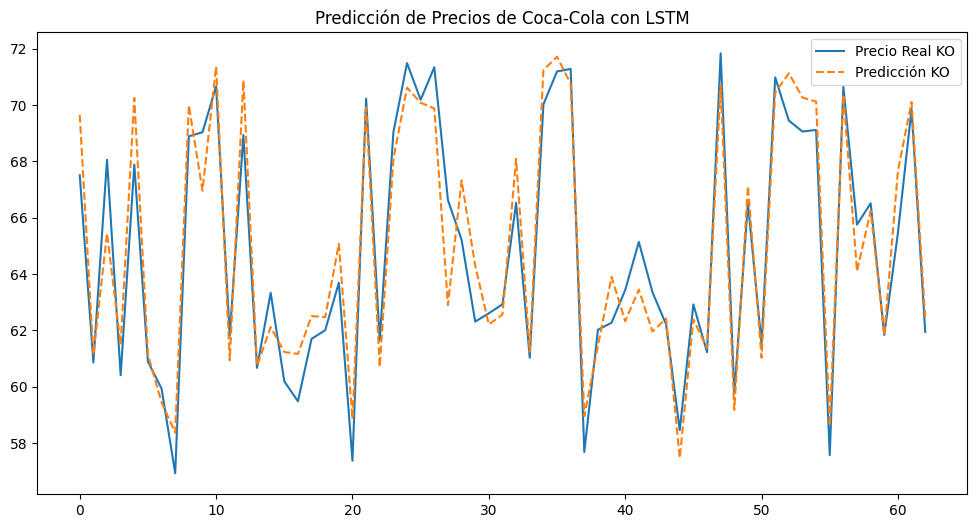

In [9]:
# Predicciones
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Invertir la escala de los valores reales
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizar los resultados
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Precio Real KO")
plt.plot(predictions, label="Predicción KO", linestyle="dashed")
plt.legend()
plt.title("Predicción de Precios de Coca-Cola con LSTM")
plt.show()